In [21]:
import matplotlib.pyplot as plt
import numpy as np

In [22]:
g = 1

In [23]:
# Константы
# Время моделирования
T = 20
# Delta t
dt = 0.01

# Заданные параметры
T_ob = 1
Xi = 0.75
K_ob = 1
# Время запаздывания
tau_ob = 0.1

In [24]:
class AdjustableModule:
    '''Объект регулирования'''
    __y_1 = 0
    __y_2 = 0

    def calc_output(self, input_value: float):
        k_1 = dt * (self.__y_2)
        m_1 = dt * ((-2*Xi/T_ob)*self.__y_2 - 1/(T_ob**2)*self.__y_1 + K_ob/T_ob*input_value)
        k_2 = dt * (self.__y_2 + k_1 / 2)
        m_2 = dt * ((-2*Xi/T_ob)*(self.__y_2 + m_1/2) - 1/(T_ob**2)*(self.__y_1 + k_1/2) + K_ob/T_ob*input_value)
        k_3 = dt * (self.__y_2 + k_2 / 2)
        m_3 = dt * ((-2*Xi/T_ob)*(self.__y_2 + m_2/2) - 1/(T_ob**2)*(self.__y_1 + k_2/2) + K_ob/T_ob*input_value)
        k_4 = dt * (self.__y_2 + k_3)
        m_4 = dt * ((-2*Xi/T_ob)*(self.__y_2 + m_3) - 1/(T_ob**2)*(self.__y_1 + k_3) + K_ob/T_ob*input_value)
        
        self.__y_1 += (1/6) * (k_1 + 2*k_2 + 2*k_3 + k_4)
        self.__y_2 += (1/6) * (m_1 + 2*m_2 + 2*m_3 + m_4)

        return self.__y_1
    
    def __str__(self):
        return f"y_1: {self.__y_1}, y_2: {self.__y_2}"

In [25]:
t_vals = []
t = 0
y = []

ob = AdjustableModule()

while t < T:
    y_val = ob.calc_output(input_value=g)
    y.append(y_val)
    t_vals.append(t)
    t += dt

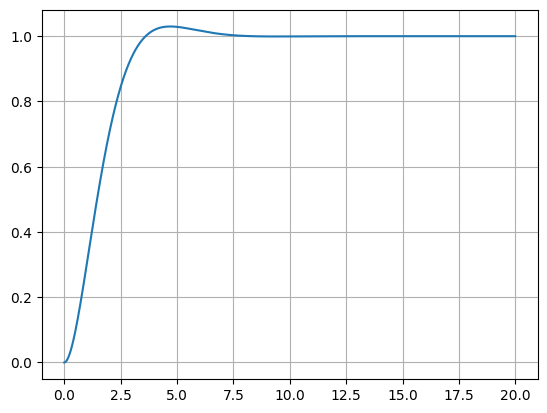

In [26]:
plt.grid()
plt.plot(t_vals, y)

Теперь, пусть выход объекта регулирования - $` z(t) `$

In [27]:
z_values = []

Добавим звено запаздывания

In [28]:
class DelayModule:
    def __init__(self, tau: float):
        self.tau = tau
        self.input_values = []
        self.shift = int(tau / dt)

    def calc_output(self, input_value):
        self.input_values.append(input_value)
        if len(self.input_values) < self.shift:
            return 0
        return self.input_values[len(self.input_values) - self.shift]
    
    def __str__(self):
        return f"INPUT VALS {len(self.input_values)}"

In [29]:
t_vals = []
t = 0

y_values = []
z_values = []

ob = AdjustableModule()
delay_module = DelayModule(tau=tau_ob)

x = 0
y_val = 0

while t < T:
    # Обратная связь
    x = g - y_val
    z_val = ob.calc_output(input_value=x)
    z_values.append(z_val)
    y_val = delay_module.calc_output(input_value=z_val)
    y_values.append(y_val)
    t_vals.append(t)
    t += dt

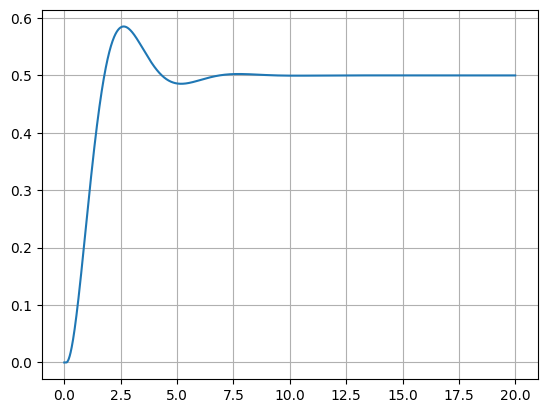

In [30]:
plt.plot(t_vals, y_values)
plt.grid()
plt.show()

Добавим звено регулирования

In [31]:
class ControlModule:
    __integ_part = 0
    __previous_input = 0

    '''ПИД регулятор'''
    def __init__(self, q_1, q_2, q_3):
        self.q_1 = q_1
        self.q_2 = q_2
        self.q_3 = q_3

    def calc_output(self, input_value):
        self.__integ_part += input_value*dt
        input_direvative = (input_value - self.__previous_input) / dt
        output = self.q_1 + self.q_2 * self.__integ_part + self.q_3 * input_direvative
        self.__previous_input = input_value
        return output
    
    def __str__(self):
        return f"Integral: {self.__integ_part}, previous_input: {self.__previous_input}"

Теперь, пусть выход объекта регулирования - $` u(t) `$

In [32]:
T = 40

t_vals = []
t = 0

x = 0
u_val = 0
z_val = 0
y_val = 0

u_values = []
y_values = []
z_values = []

# Инициализируем веса случаными значениями
q_vals = [0.5, 0.1, 0.7]

ob = AdjustableModule()
delay_module = DelayModule(tau=tau_ob)
pid_reg = ControlModule(q_1=q_vals[0],
                        q_2=q_vals[1],
                        q_3=q_vals[2])

while t < T:
    # Обратная связь
    x = g - y_val

    u_val = pid_reg.calc_output(input_value=x)
    u_values.append(u_val)

    z_val = ob.calc_output(input_value=u_val)
    z_values.append(z_val)

    y_val = delay_module.calc_output(input_value=z_val)
    y_values.append(y_val)

    t_vals.append(t)
    t += dt

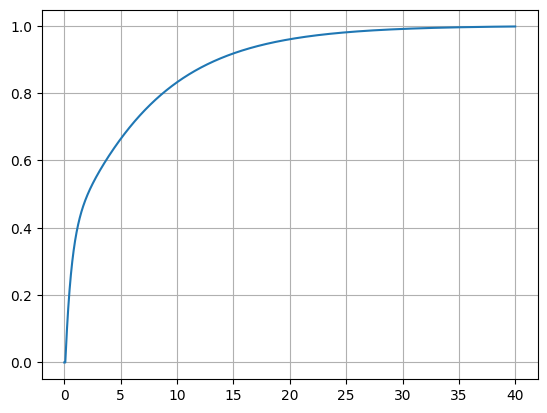

In [33]:
plt.grid()
plt.plot(t_vals, y_values)

## Подсчет интегрального критерия качетсва

$$ I_3(t) = \int_0^t \left( x^2(t) + \mu \cdot \left( \frac{dx(t)}{dt} \right)^2 \right) dt $$

In [34]:
# Для использования сотставного интегрального критерия качества необходимо выбрать mu
# Так как t_рег / 6 <= mu < t_рег / 3

# Пока возьму случайное значение
mu = 1

In [35]:
T = 40

t_vals = []
t = 0

x = 0
u_val = 0
z_val = 0
y_val = 0

x_values = []
u_values = []
y_values = []
z_values = []

q_vals = [0.5, 0.1, 0.7]

ob = AdjustableModule()
delay_module = DelayModule(tau=tau_ob)
pid_reg = ControlModule(q_1=q_vals[0],
                        q_2=q_vals[1],
                        q_3=q_vals[2])

# Значения интегрального критерия качества
I = 0
I_values = []

while t < T:
    # Обратная связь
    x = g - y_val
    x_values.append(x)

    if len(x_values) > 1:
        dx = (x_values[-1] - x_values[-2]) / dt
    else:
        dx = 0

    # Обновление критерия качества
    I += (x**2 + mu**2 * dx**2) * dt
    I_values.append(I)


    u_val = pid_reg.calc_output(input_value=x)
    u_values.append(u_val)

    z_val = ob.calc_output(input_value=u_val)
    z_values.append(z_val)

    y_val = delay_module.calc_output(input_value=z_val)
    y_values.append(y_val)

    t_vals.append(t)
    t += dt

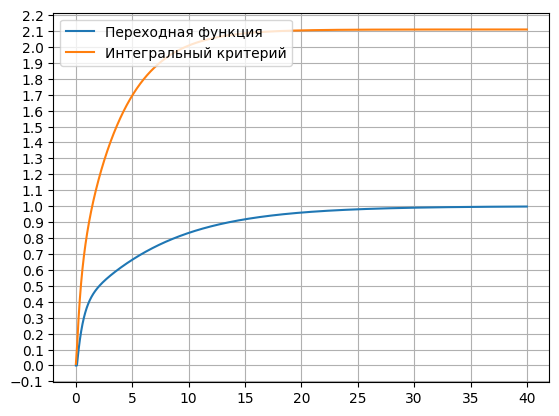

In [36]:
from matplotlib.ticker import MultipleLocator

fig = plt.figure()
ax1 = fig.add_subplot()

ax1.plot(t_vals, y_values, label='Переходная функция')
ax1.plot(t_vals, I_values, label='Интегральный критерий')
ax1.yaxis.set_major_locator(MultipleLocator(0.1))

plt.legend(loc='upper left')
plt.grid()
plt.show()

In [37]:
np.sum(np.array([1, 2, 3]) * 0.1)

np.float64(0.6000000000000001)

In [39]:
def calc_du_dq_j(x_values, q_vals, j, xi_j_values):
    x_current = x_values[-1] if len(x_values) >= 1 else 0
    x_prev = x_values[-2] if len(x_values) >= 2 else 0
    direct_contibs = {
        "1": x_values[-1],
        "2": np.sum(np.array(x_values) * dt),
        "3": (x_current - x_prev) / dt
    }
    return direct_contibs[str(j)] - q_vals[0]*xi_j_values[-1] - q_vals[1]*np.sum(np.array(xi_j_values)*dt) - q_vals[2]*(xi_j_values[-1] - xi_j_values[-2])/dt

def criterion_derivative_delta(x_values, xi_j):
    error = x_values[-1] if len(x_values) >= 1 else 0
    prev_error = x_values[-2] if len(x_values) >= 2 else 0
    return -2 * (error + 2*mu**2 * (error - prev_error) / dt * 1/dt)*xi_j*dt

In [40]:
l_rate = 1e-3
epsilon = 1e-3


# q_vals = [0.5, 0.1, 0.7]
q_vals = [0, 0, 0]

I_values = []

for i in range(100):
    print(i)
    T = 20

    t_vals = []
    t = 0

    x = 0
    u_val = 0
    z_val = 0
    y_val = 0

    x_values = []
    u_values = []
    y_values = []
    z_values = []

    ob = AdjustableModule()
    delay_module = DelayModule(tau=tau_ob)
    pid_reg = ControlModule(q_1=q_vals[0],
                            q_2=q_vals[1],
                            q_3=q_vals[2])

    # Значение интегрального критерия качества
    I = 0

    dI_dq1_value = 0
    dI_dq2_value = 0
    dI_dq3_value = 0

    xi_1_values = [0, 0]
    xi_2_values = [0, 0]
    xi_3_values = [0, 0]

    xi_1_dir = 0
    xi_2_dir = 0
    xi_3_dir = 0

    while t < T:
        # Обратная связь
        x = g - y_val
        x_values.append(x)

        if len(x_values) > 1:
            dx = (x_values[-1] - x_values[-2]) / dt
        else:
            dx = 0

        # Обновление критерия качества
        I += (x**2 + mu**2 * dx**2) * dt

        u_val = pid_reg.calc_output(input_value=x)
        u_values.append(u_val)

        du_dq_1_value = calc_du_dq_j(x_values=x_values, q_vals=q_vals, j=1, xi_j_values=xi_1_values)
        du_dq_2_value = calc_du_dq_j(x_values=x_values, q_vals=q_vals, j=2, xi_j_values=xi_2_values)
        du_dq_3_value = calc_du_dq_j(x_values=x_values, q_vals=q_vals, j=3, xi_j_values=xi_3_values)

        xi_1_values.append(ob.calc_output(input_value=du_dq_1_value))
        xi_2_values.append(ob.calc_output(input_value=du_dq_2_value))
        xi_3_values.append(ob.calc_output(input_value=du_dq_3_value))

        xi_1_dir += criterion_derivative_delta(x_values, xi_j=xi_1_values[-1])
        xi_2_dir += criterion_derivative_delta(x_values, xi_j=xi_2_values[-1])
        xi_3_dir += criterion_derivative_delta(x_values, xi_j=xi_3_values[-1])

        z_val = ob.calc_output(input_value=u_val)
        z_values.append(z_val)

        y_val = delay_module.calc_output(input_value=z_val)
        y_values.append(y_val)

        t_vals.append(t)
        t += dt
        
    I_values.append(I)
    q_vals[0] = q_vals[0] - l_rate * xi_1_dir
    q_vals[1] = q_vals[1] - l_rate * xi_2_dir
    q_vals[2] = q_vals[2] - l_rate * xi_3_dir

0
1
2
3


/tmp/ipykernel_331/3911112502.py:9: RuntimeWarning: overflow encountered in scalar multiply
  return direct_contibs[str(j)] - q_vals[0]*xi_j_values[-1] - q_vals[1]*np.sum(np.array(xi_j_values)*dt) - q_vals[2]*(xi_j_values[-1] - xi_j_values[-2])/dt
/tmp/ipykernel_331/1059772773.py:10: RuntimeWarning: invalid value encountered in scalar add
  m_2 = dt * ((-2*Xi/T_ob)*(self.__y_2 + m_1/2) - 1/(T_ob**2)*(self.__y_1 + k_1/2) + K_ob/T_ob*input_value)
/tmp/ipykernel_331/51068144.py:59: RuntimeWarning: overflow encountered in scalar power
  I += (x**2 + mu**2 * dx**2) * dt
/tmp/ipykernel_331/3659831054.py:14: RuntimeWarning: overflow encountered in scalar multiply
  output = self.q_1 + self.q_2 * self.__integ_part + self.q_3 * input_direvative


4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


KeyboardInterrupt: 

[np.float64(2.97641992998183), np.float64(24.00887881515824), np.float64(9.415946028386661e+271), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), n

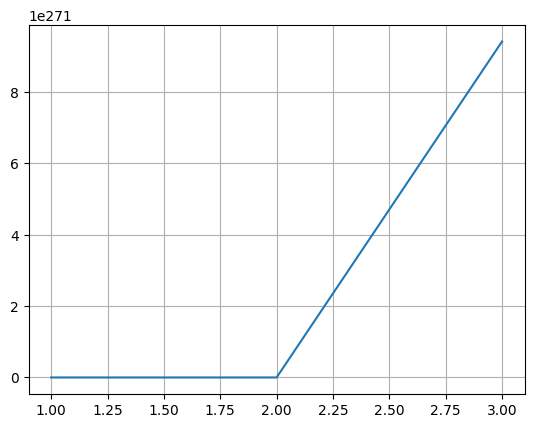

In [28]:
plt.grid()
plt.plot([i for i in range(1, 101)], I_values)
print(I_values)

In [ ]:
# def W_ob(p):
    

In [ ]:
# def criterion_q_j_direvative(x_values: np.array, dx_dt_values: np.array, W_ob, q_vals, j):
#     direct_contribs = {
#         "1": x_values,
#         "2": np.cumsum((map(lambda x: x*dt, x_values))),
#         "3": dx_dt_values
#     }

#     direct_contrib = direct_contribs[j]

#     denominator = 1 / W_ob(1) + q_vals[0] + q_vals[1] * np.cumsum(x_values) * dt + q_vals[2] * dx_dt_values
    
#     # Подынтегральное выражение
#     integrand = -(2 * x_values + 2 * mu**2 * dx_dt_values) * direct_contrib / denominator
    
#     # Численное интегрирование
#     return np.trapezoid(integrand, dx=dt)

Для оптимизации параметров $` q_1, q_2, q_3 `$ реализуем алгоритм градиентного спуска

In [ ]:
def grad_descent(q_vals):
    # Шаг один - считаем частные производные, полученные аналитически:
    pass